# Trainer API를 활용한 Fine Tuning 하기.

## 1. 데이터와 configuration 불러오기

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"
import sys
from omegaconf import OmegaConf

from sklearn.metrics import accuracy_score, f1_score

import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    EvalPrediction,
    Trainer,
    TrainingArguments
)



* `pl.LightningDataModule`로 datasets의 전처리 과정을 관리하는 코드 만듦.

In [ ]:
sys.path.append('/root/nlp-with-transformers')
from src.data import EmotionDataModule

* 평가지표 정의하기
    * Trainer 내부에서 사용할 `compute_metrics`을 정의함.
    * 모델 학습 과정에서 `EvalPrediction`객체 (has attribute predictions, label_ids)를 전달받아서 평가지표 계산이 가능함.

In [ ]:
def compute_metrics(pred:EvalPrediction):
    """Get EvalPrediction and Calculate the metrics"""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy":acc, "f1":f1}

* configuration은 크게 data, model, training쪽을 나눠서 관리하는게 좋음.

In [3]:
config = OmegaConf.load('conf/ft.yaml')

In [4]:
tokenizer = AutoTokenizer.from_pretrained(config.model.pretrained_model_name_or_path)
dm = EmotionDataModule(tokenizer=tokenizer, **OmegaConf.to_container(config.data))
dm.setup()

No config specified, defaulting to: emotion/split
No config specified, defaulting to: emotion/split
Found cached dataset emotion (/root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-805eceb002e5c82e.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-e72b1f240cb76b39.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-363a00d3f7a34dfe.arrow


* 사전학습된 모델 로드

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModelForSequenceClassification.from_pretrained(
    config.model.pretrained_model_name_or_path, 
    num_labels=dm.num_classes
).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

* 다른 arguments에 의존성이 있는 training args를 정의 및 trainer 실행.

In [6]:
config.training.output_dir = f"{config.model.pretrained_model_name_or_path}-finetuned-emotion"
config.training.logging_steps = len(dm.ds['train']) // config.training.per_device_train_batch_size
training_args = TrainingArguments(**OmegaConf.to_container(config.training))

In [8]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=dm.ds['train'],
                  eval_dataset=dm.ds['validation'],
                  data_collator=dm.get_collate_fn()
                 )

trainer.train()

/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.785800,0.280399,0.912000,0.909511
2,0.217000,0.179996,0.930500,0.930353
3,0.150600,0.168231,0.935000,0.935032


TrainOutput(global_step=750, training_loss=0.38445380655924477, metrics={'train_runtime': 101.9885, 'train_samples_per_second': 470.641, 'train_steps_per_second': 7.354, 'total_flos': 1078278745731840.0, 'train_loss': 0.38445380655924477, 'epoch': 3.0})

* predicts를 통해 예측값을 받을 수 있음.

In [13]:
predicts = trainer.predict(dm.ds['validation'])
predicts

PredictionOutput(predictions=array([[ 5.125517  , -0.85585594, -0.9488167 , -1.1720947 , -0.76221216,
        -1.7000798 ],
       [ 5.201852  , -0.8692229 , -1.8879997 , -0.52464515, -0.25385183,
        -1.719322  ],
       [-1.4356955 ,  2.7226503 ,  3.0036068 , -1.5660727 , -2.0291173 ,
        -1.7384019 ],
       ...,
       [-1.1659471 ,  5.2157    , -0.32684675, -1.3742566 , -1.719369  ,
        -1.261219  ],
       [-1.8680072 ,  2.8251667 ,  3.0821369 , -1.690891  , -1.9406939 ,
        -1.5378581 ],
       [-1.254271  ,  5.100617  , -0.36024407, -1.7757343 , -1.649835  ,
        -0.5117977 ]], dtype=float32), label_ids=array([0, 0, 2, ..., 1, 1, 1]), metrics={'test_loss': 0.16823114454746246, 'test_accuracy': 0.935, 'test_f1': 0.9350321299504437, 'test_runtime': 1.3004, 'test_samples_per_second': 1538.022, 'test_steps_per_second': 24.608})

* 오차 행렬

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [20]:
def plot_confusion_matrix(y_pred, y_true, labels):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized Confusion matrix")
    plt.show()

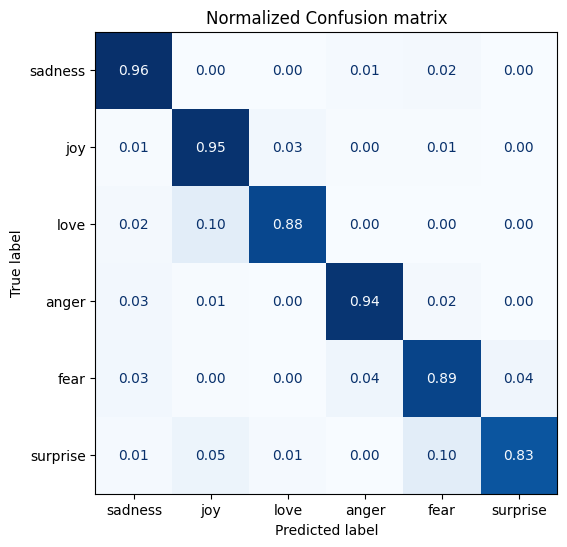

In [22]:
import numpy as np
y_preds = np.argmax(predicts.predictions, axis=1)
plot_confusion_matrix(y_preds, dm.ds['validation']['label'], dm.id2label)